# **San-Diego-Traffic-Collision-Analysis**

# 1 – Introduction and Business Analysis

## 1.1 Business Understanding  
Traffic safety is a top priority for regional planners, public safety officials, and transportation engineers. In San Diego County, collisions impose significant human and economic costs—lost productivity, emergency response expenditures, and, most importantly, injuries and fatalities. By systematically analyzing historical collision data, stakeholders can:

- Identify high-risk corridors and intersection types  
- Understand the influence of environmental factors (weather, lighting, road geometry)  
- Guide targeted interventions (signal timing adjustments, signage improvements, enforcement campaigns)  
- Monitor the impact of safety programs over time  

Our capstone aims to deliver data-driven insights that inform resource allocation and policy decisions, ultimately reducing collision severity and improving public safety.

## 1.2 About the Data  
This analysis leverages the San Diego Association of Governments (SANDAG) portal, which aggregates all reported collisions in San Diego County from 2014 through 2023. Every traffic crash for which a law-enforcement officer completes a collision report in the region is included. The California Highway Patrol (CHP) compiles these reports from local agencies into the Statewide Integrated Traffic Records System (SWITRS). SANDAG then downloads, validates, and enriches the SWITRS subset for San Diego, ensuring geographic accuracy and consistency for regional planning purposes. Key attributes include:

- **Temporal span:** January 1, 2014 – December 31, 2023  
- **Geography:** All incorporated and unincorporated areas of San Diego County  
- **Core variables:**  
  - Collision date and time  
  - Location identifiers (primary/secondary road, latitude/longitude)  
  - Injury and fatality counts  
  - Environmental conditions (weather, lighting)  
  - Collision severity and party counts  

## 1.3 Research Objectives  
1. **Exploratory Data Analysis**  
   • Uncover patterns in injury and fatality distributions  
   • Examine correlations with environmental and temporal factors  
2. **Data Preparation**  
   • Clean missing or duplicate entries  
   • Engineer features (e.g. total casualties, day-of-week flags)  
3. **Baseline Modeling**  
   • Develop a regression model to predict total casualties  
   • Evaluate using Mean Absolute Error (MAE) and R-squared  
4. **Actionable Insights**  
   • Highlight key risk factors for targeted interventions  
   • Provide recommendations for future data collection and analysis  


# 2 – Environment Setup

In [275]:
# 2.1 Import core libraries
import os
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# inline plotting
%matplotlib inline


# 3 – Data Understanding

Next we load the CSV into a DataFrame, inspect shape, columns, head and data types  


In [268]:
# 3.1 Load raw data

df = pd.read_csv('SWITRS_2023.csv', low_memory=False)

In [269]:
# 3.2 Basic inspection
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (251098, 44)
Columns: ['ACCIDENT YEAR', 'DAY OF WEEK', 'PRIMARY RD', 'SECONDARY RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION', 'WEATHER', 'STATE HWY IND', 'POSTMILE', 'COLLISION SEVERITY', 'NUMBER KILLED', 'NUMBER INJURED', 'PARTY COUNT', 'PCF VIOL CATEGORY', 'TYPE OF COLLISION', 'MVIW', 'PED ACTION', 'ROAD SURFACE', 'ROAD CONDITION', 'LIGHTING', 'CONTROL DEVICE', 'PEDESTRIAN ACCIDENT', 'BICYCLE ACCIDENT', 'MOTORCYCLE ACCIDENT', 'ALCOHOL INVOLVED', 'STWD VEHTYPE AT FAULT', 'COUNT SEVERE INJ', 'COUNT VISIBLE INJ', 'COUNT COMPLAINT PAIN', 'COUNT PED KILLED', 'COUNT PED INJURED', 'COUNT BICYCLIST KILLED', 'COUNT BICYCLIST INJURED', 'COUNT MC KILLED', 'COUNT MC INJURED', 'LATITUDE sandag', 'LONGITUDE sandag', 'X', 'Y', 'Shape', 'CASE ID', 'Location sandag', 'Reservation sandag']


,ACCIDENT YEAR,DAY OF WEEK,PRIMARY RD,SECONDARY RD,DISTANCE,DIRECTION,INTERSECTION,WEATHER,STATE HWY IND,POSTMILE,...,COUNT MC KILLED,COUNT MC INJURED,LATITUDE sandag,LONGITUDE sandag,X,Y,Shape,CASE ID,Location sandag,Reservation sandag
0,2014,Sunday,SOUTH RANCHO SANTA FE RD,LAKE SAN MARCOS DR,0.0,"Not Stated, in intersection",Intersection,Clear,Not State Highway,NaN,...,0,0,33.126694,-117.213597,6.266666e+06,1.991086e+06,0xB6080000010C205E0280CAE7574180AC0B00AE613E41,6659432,San Marcos,Not Reservation Land
1,2014,Thursday,RT 5,RT 54,800.0,North,Not Intersection,Clear,State Highway,9.74,...,0,0,32.659900,-117.107730,6.297679e+06,1.820967e+06,0xB6080000010C809835C81306584180EDFFA626C93B41,6659434,National City,Not Reservation Land
2,2014,Thursday,RT 8,FASHION VALLEY RD,10.0,West,Not Intersection,Clear,State Highway,2.08,...,0,0,32.760590,-117.169030,6.279136e+06,1.857762e+06,0xB6080000010CC07BE0EAF7F3574100B11DB9E1583C41,6659433,San Diego,Not Reservation Land
3,2014,Thursday,RT 805,UNIVERSITY AV,400.0,North,Not Intersection,Clear,State Highway,16.03,...,0,0,32.752230,-117.124200,6.292892e+06,1.854602e+06,0xB6080000010CF03D60F266015841C0B7F98E894C3C41,6659437,San Diego,Not Reservation Land
4,2014,Wednesday,RT 15,RT 94,20.0,South,Not Intersection,Clear,State Highway,2.26,...,0,0,32.715960,-117.118000,6.294688e+06,1.841389e+06,0xB6080000010CE0B54F0728035841009F7B5FED183C41,6659443,San Diego,Not Reservation Land


In [27]:
# 3.3 Data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251098 entries, 0 to 251097
Data columns (total 44 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ACCIDENT YEAR            251098 non-null  int64  
 1   DAY OF WEEK              251098 non-null  object 
 2   PRIMARY RD               251098 non-null  object 
 3   SECONDARY RD             251094 non-null  object 
 4   DISTANCE                 251098 non-null  float64
 5   DIRECTION                251098 non-null  object 
 6   INTERSECTION             251098 non-null  object 
 7   WEATHER                  251098 non-null  object 
 8   STATE HWY IND            251098 non-null  object 
 9   POSTMILE                 21779 non-null   float64
 10  COLLISION SEVERITY       251098 non-null  object 
 11  NUMBER KILLED            251098 non-null  int64  
 12  NUMBER INJURED           251098 non-null  int64  
 13  PARTY COUNT              251098 non-null  int64  
 14  PCF 

## Interpretation

When we loaded the San Diego collision data, we saw the following:

1. **Dataset size**  
   1  The table contains 251 098 rows (one per reported collision) and 44 columns (variables)

2. **Variable categories**  
   1  Temporal and identification  
      - ACCIDENT YEAR  
      - DAY OF WEEK  
      - CASE ID  
   2 Location and geometry  
      - PRIMARY RD, SECONDARY RD, DISTANCE, DIRECTION, INTERSECTION  
      - LATITUDE sandag, LONGITUDE sandag, X, Y, Shape, Location sandag, Reservation sandag  
   3 Collision details  
      - COLLISION SEVERITY, TYPE OF COLLISION, PCF VIOL CATEGORY, STWD VEHTYPE AT FAULT  
   4 Casualties and counts  
      - NUMBER INJURED, NUMBER KILLED, PARTY COUNT  
      - COUNT SEVERE INJ, COUNT VISIBLE INJ, COUNT COMPLAINT PAIN  
      - COUNT PED INJURED/KILLED, COUNT BICYCLIST INJURED/KILLED, COUNT MC INJURED/KILLED  
   5 Environmental and condition flags  
      - WEATHER, LIGHTING, ROAD SURFACE, ROAD CONDITION, CONTROL DEVICE, ALCOHOL INVOLVED  
      - PEDESTRIAN ACCIDENT, BICYCLE ACCIDENT, MOTORCYCLE ACCIDENT, MVIW, PED ACTION  

3. **Data types**  
   1  44 total columns  
   2  20 object (string) fields  
   3  6 float64 fields  
   4  4 int64 fields  
   5  4 bool fields  

4. **Missing-value patterns**  
   1  POSTMILE is present in only 21 779 records  
   2  CONTROL DEVICE appears in 72 648 records  
   3  LATITUDE and LONGITUDE each have about 213 817 non-null entries  
   4  Geometry column Shape has 209 472 non-null entries  
   5  Most core numeric fields (NUMBER INJURED, NUMBER KILLED, PARTY COUNT) are fully populated  

5. **Implications for cleaning**  
   1  Drop or archive duplicate CASE ID entries  
   2  Remove or simplify geometry fields (Shape, X, Y) unless needed for mapping  
   3  Decide on strategy for sparse columns (POSTMILE, CONTROL DEVICE)  
   4  Ensure numeric fields are zero-filled or imputed where appropriate  
   5  Convert object-type flags to categorical or boolean as needed  

This initial understanding guides our next steps in data cleaning and feature engineering  

---




# 4 – Data Cleaning

In this section we will  

1. Remove duplicate records  
2. Drop unneeded geometry columns  
3. Handle missing values in numeric, categorical, and boolean fields  
4. Verify that the dataset is ready for analysis  


### 4.1 Remove Duplicate Records

We identify duplicates by the unique `CASE ID` and drop any repeats.

```python
# Count before de-duplication
initial_count = len(df)

# Drop duplicates on the case identifier
df = df.drop_duplicates(subset="CASE ID")

# Report how many rows were removed
removed = initial_count - len(df)
print(f"Removed {removed} duplicate records ({removed/initial_count:.2%} of total).")


### 4.2 Drop Unnecessary Geometry Columns
The fields related to shapefile geometry and projection (Shape, X, Y, Location sandag, Reservation sandag) are not needed for this EDA and will be dropped to reduce memory usage.

In [111]:
geo_cols = [
    "Shape",
    "X",
    "Y",
    "Location sandag",
    "Reservation sandag"
]

# Only drop if present
geo_to_drop = [col for col in geo_cols if col in df.columns]
if geo_to_drop:
    df = df.drop(columns=geo_to_drop)
    print("Dropped geometry columns:", geo_to_drop)
else:
    print("No geometry columns to drop.")


No geometry columns to drop.


### 4.3 Handle Missing Values

In [120]:
# 4.3.1 Numeric Fields

# Core injury/fatality counts → fill missing with zero
numeric_zero = ["NUMBER KILLED", "NUMBER INJURED", "PARTY COUNT"]
df[numeric_zero] = df[numeric_zero].fillna(0)

# DISTANCE → median imputation; POSTMILE → drop if present (very sparse)
if "DISTANCE" in df.columns:
    df["DISTANCE"] = df["DISTANCE"].fillna(df["DISTANCE"].median())

if "POSTMILE" in df.columns:
    df = df.drop(columns=["POSTMILE"])
    print("Dropped 'POSTMILE' due to high sparsity.")


In [122]:
# 4.3.2 Categorical Fields
cat_cols = [
    "DAY OF WEEK",
    "WEATHER",
    "LIGHTING",
    "ROAD SURFACE",
    "ROAD CONDITION",
    "CONTROL DEVICE",
    "COLLISION SEVERITY",
    "TYPE OF COLLISION"
]

for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown")

In [124]:
# 4.3.3 Boolean Fields

bool_cols = df.select_dtypes(include="bool").columns.tolist()
if bool_cols:
    df[bool_cols] = df[bool_cols].fillna(False)

### 4.4 Verification of Cleaning

In [127]:
total_missing = df.isnull().sum().sum()
print(f"Total missing values remaining: {total_missing}")

remaining = df.isnull().sum()
print("Remaining missing values per column:\n", remaining[remaining > 0])


Total missing values remaining: 116428
Remaining missing values per column:
 SECONDARY RD                 4
PCF VIOL CATEGORY         1612
MVIW                      1210
STWD VEHTYPE AT FAULT    39040
LATITUDE sandag          37281
LONGITUDE sandag         37281
dtype: int64


#### 4.1 Geometry Columns

- No geometry-related columns (`Shape`, `X`, `Y`, `Location sandag`, `Reservation sandag`) were present at this stage—either previously removed or not imported—so no action was needed here.

#### 4.4 Missing‐Value Summary

- **Total missing values remaining:** 116 428  
- **Breakdown by column**  
  - `SECONDARY RD`: 4 (≈ 0%)  
  - `PCF VIOL CATEGORY`: 1 612 (≈ 0.6%)  
  - `MVIW`: 1 210 (≈ 0.5%)  
  - `STWD VEHTYPE AT FAULT`: 39 040 (≈ 15.5%)  
  - `LATITUDE sandag`: 37 281 (≈ 14.8%)  
  - `LONGITUDE sandag`: 37 281 (≈ 14.8%)  

**Implications & Next Steps**  
- Low‐missing columns (`SECONDARY RD`, `PCF VIOL CATEGORY`, `MVIW`) can be imputed or dropped without much data loss.  
- High‐missing columns (`STWD VEHTYPE AT FAULT`, `LATITUDE sandag`, `LONGITUDE sandag`) require a decision: either exclude them from certain analyses or apply targeted imputation/alternative data sources if spatial or fault‐type insights are critical.  


# 5 – Outlier Analysis

Outliers can distort summary statistics and model fitting, but in collision data they may also represent genuinely severe events. Here we will:

1. Define an IQR-based outlier detection function  
2. Apply it to key numeric features  
3. Summarize counts and percentages of outliers  
4. Visualize with boxplots  
5. Decide on a handling strategy  

---

### 5.1 Define Outlier Detection Function

In [153]:
def detect_outliers_iqr(series, k=1.5):
    """
    Returns a Boolean mask indicating which values in `series` 
    are outliers based on the IQR method with multiplier k.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return (series < lower) | (series > upper)

### 5.2 Apply to Key Numeric Features


In [156]:
numeric_features = [
    "PARTY COUNT",
    "NUMBER INJURED",
    "NUMBER KILLED",
    "DISTANCE",
    "Total Casualties"
]

# Build a summary of outlier counts and percentages
outlier_summary = []
for col in numeric_features:
    mask = detect_outliers_iqr(df[col])
    count = mask.sum()
    pct   = count / len(df) * 100
    outlier_summary.append({
        "feature": col,
        "outlier_count": count,
        "outlier_pct": round(pct, 2)
    })

# Convert to DataFrame for display
import pandas as pd
pd.DataFrame(outlier_summary).set_index("feature")


,outlier_count,outlier_pct
feature,,
PARTY COUNT,90789,36.16
NUMBER INJURED,10459,4.17
NUMBER KILLED,2440,0.97
DISTANCE,25474,10.15
Total Casualties,10671,4.25


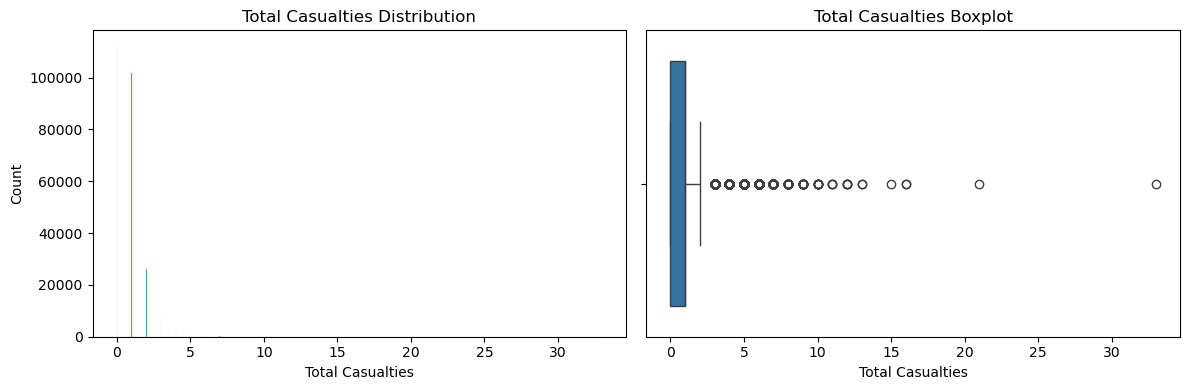

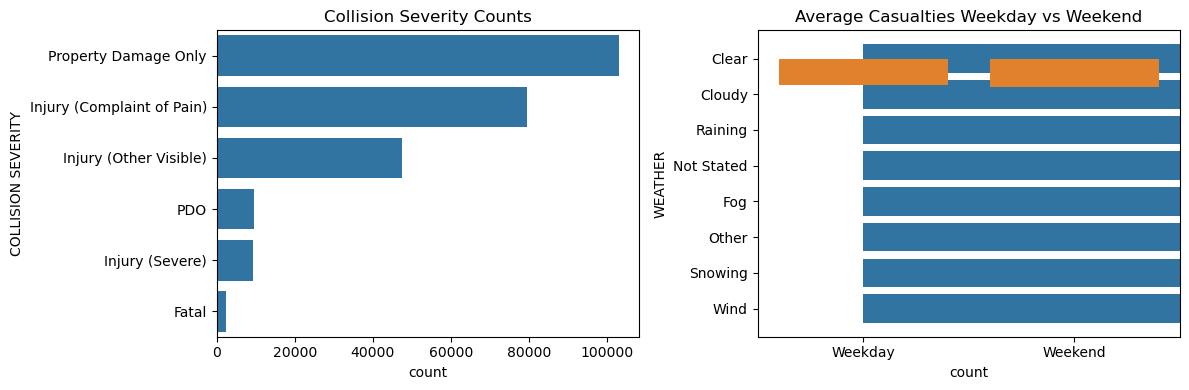

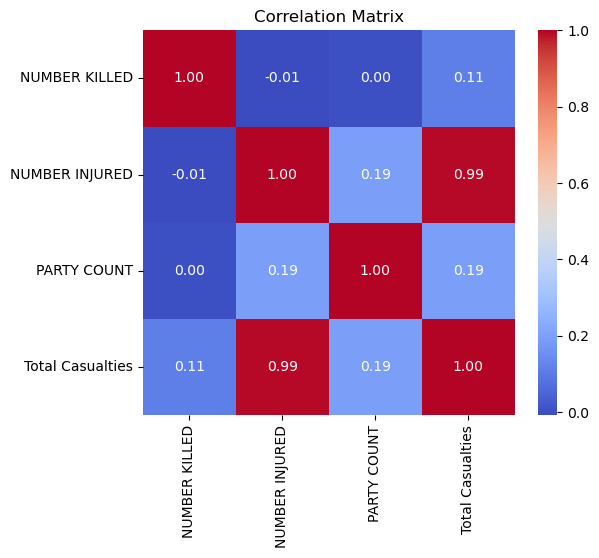

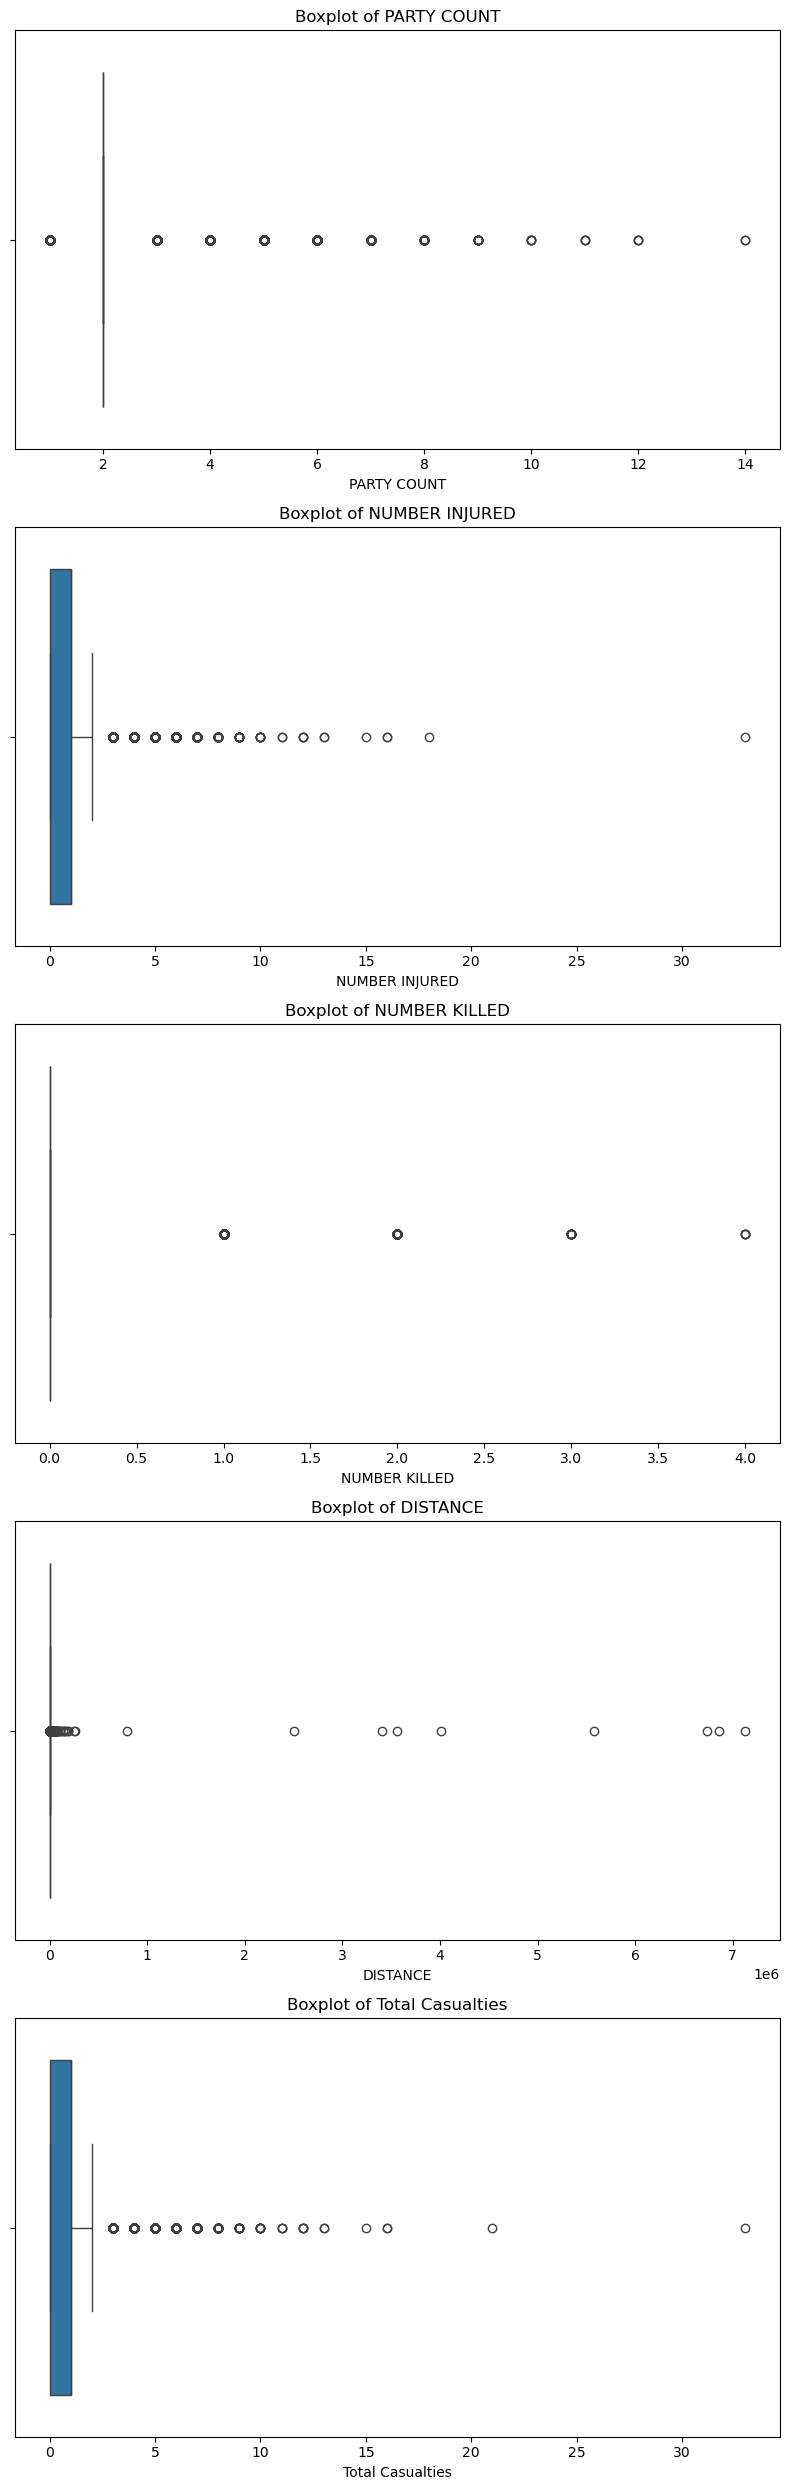

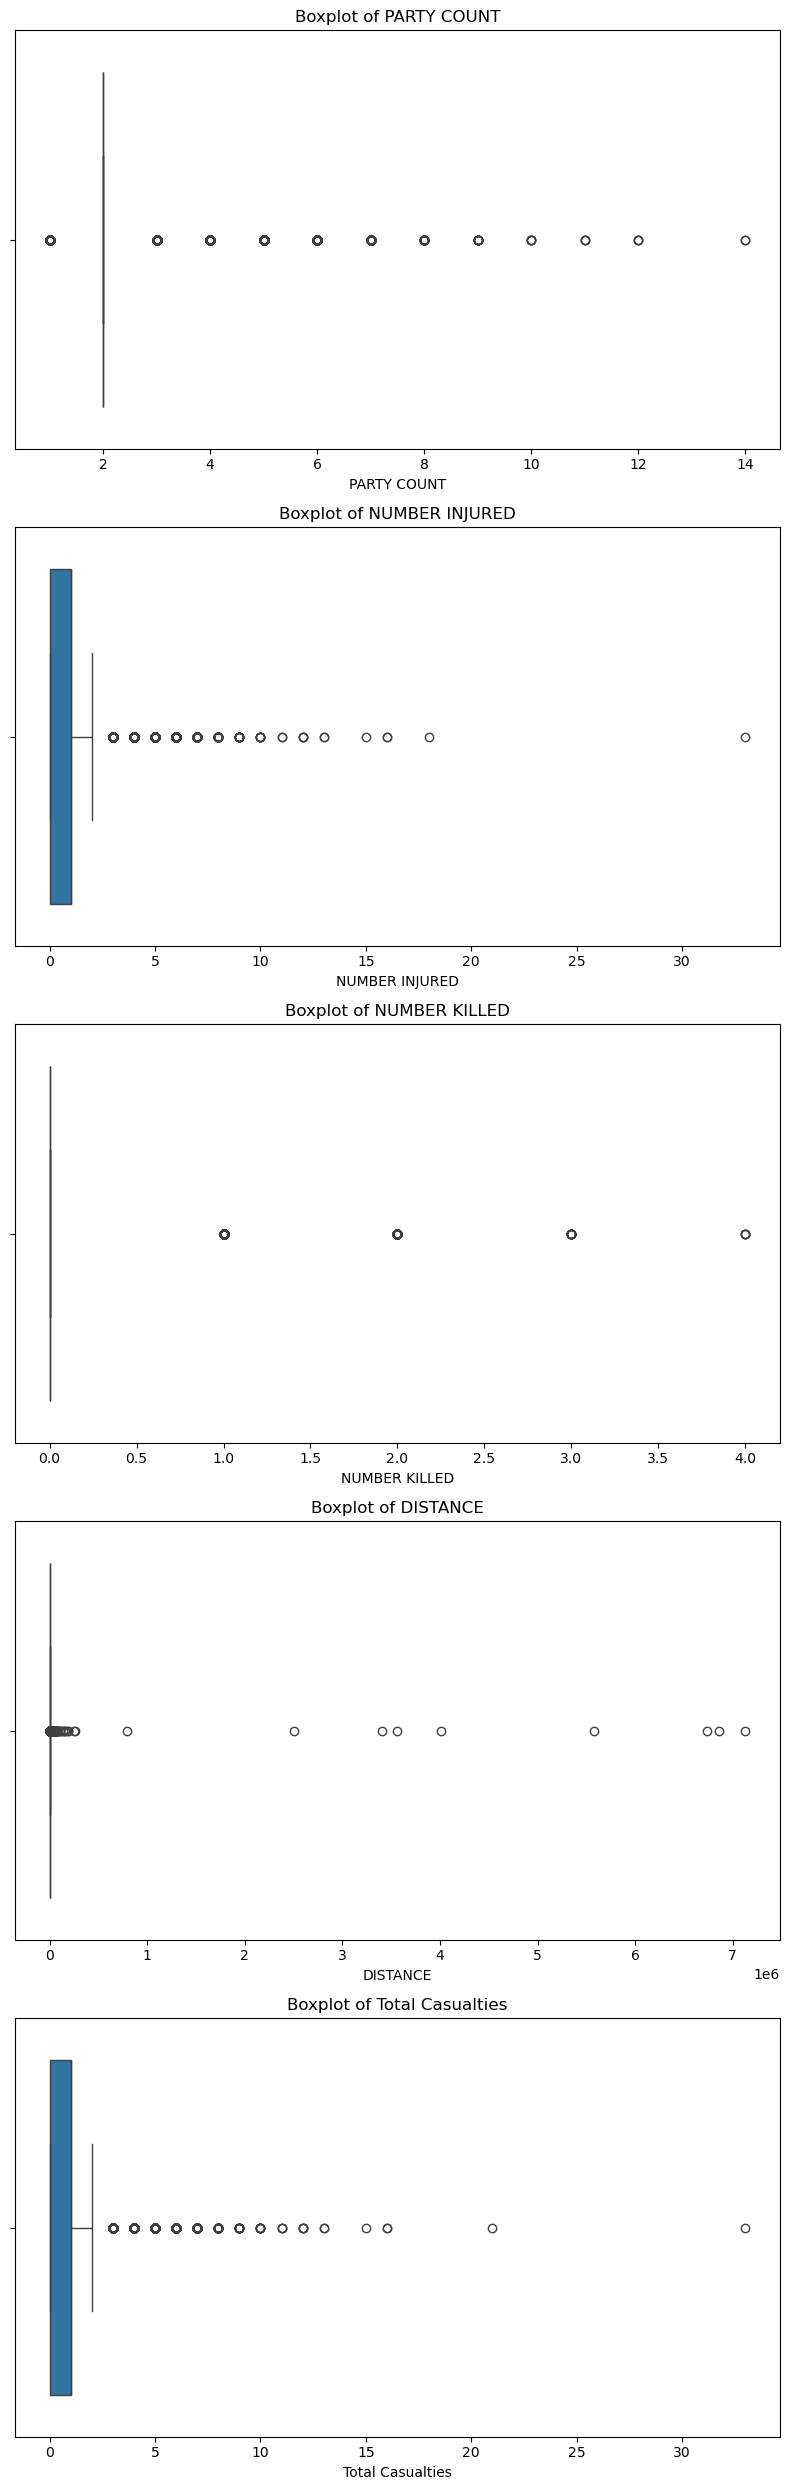

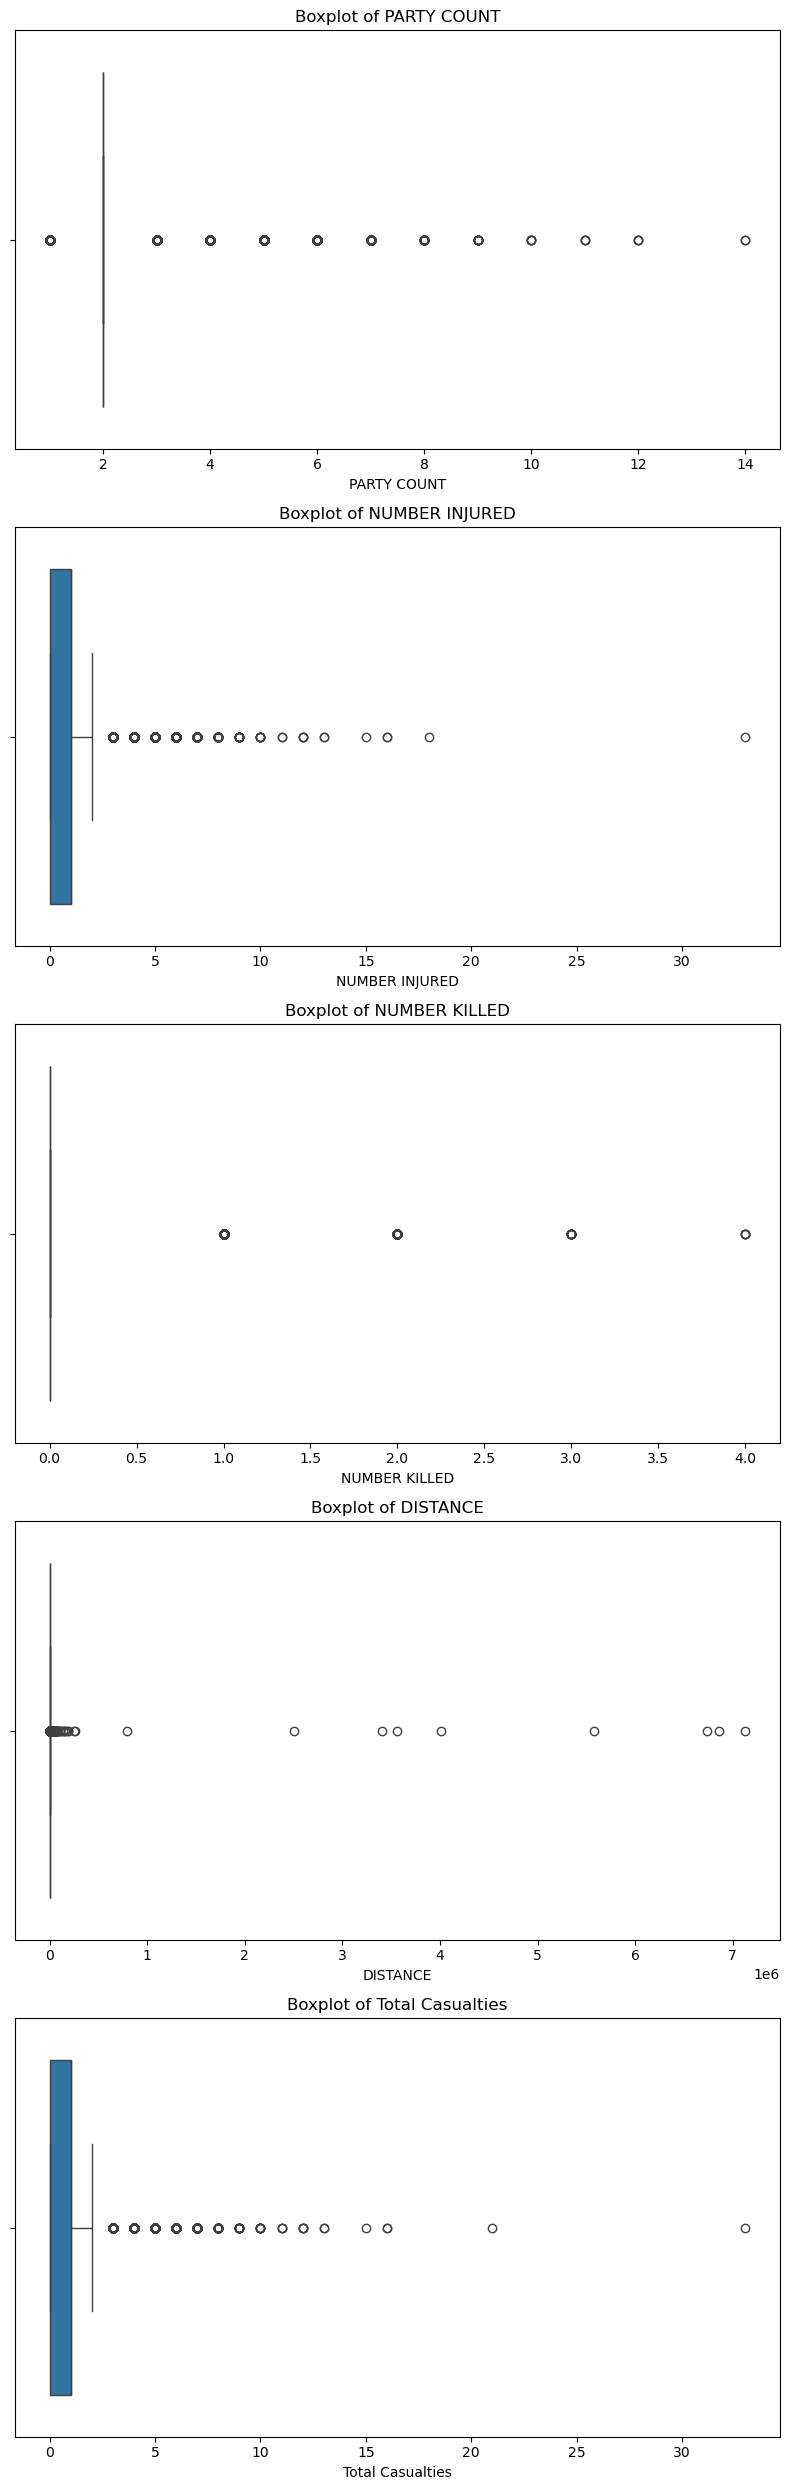

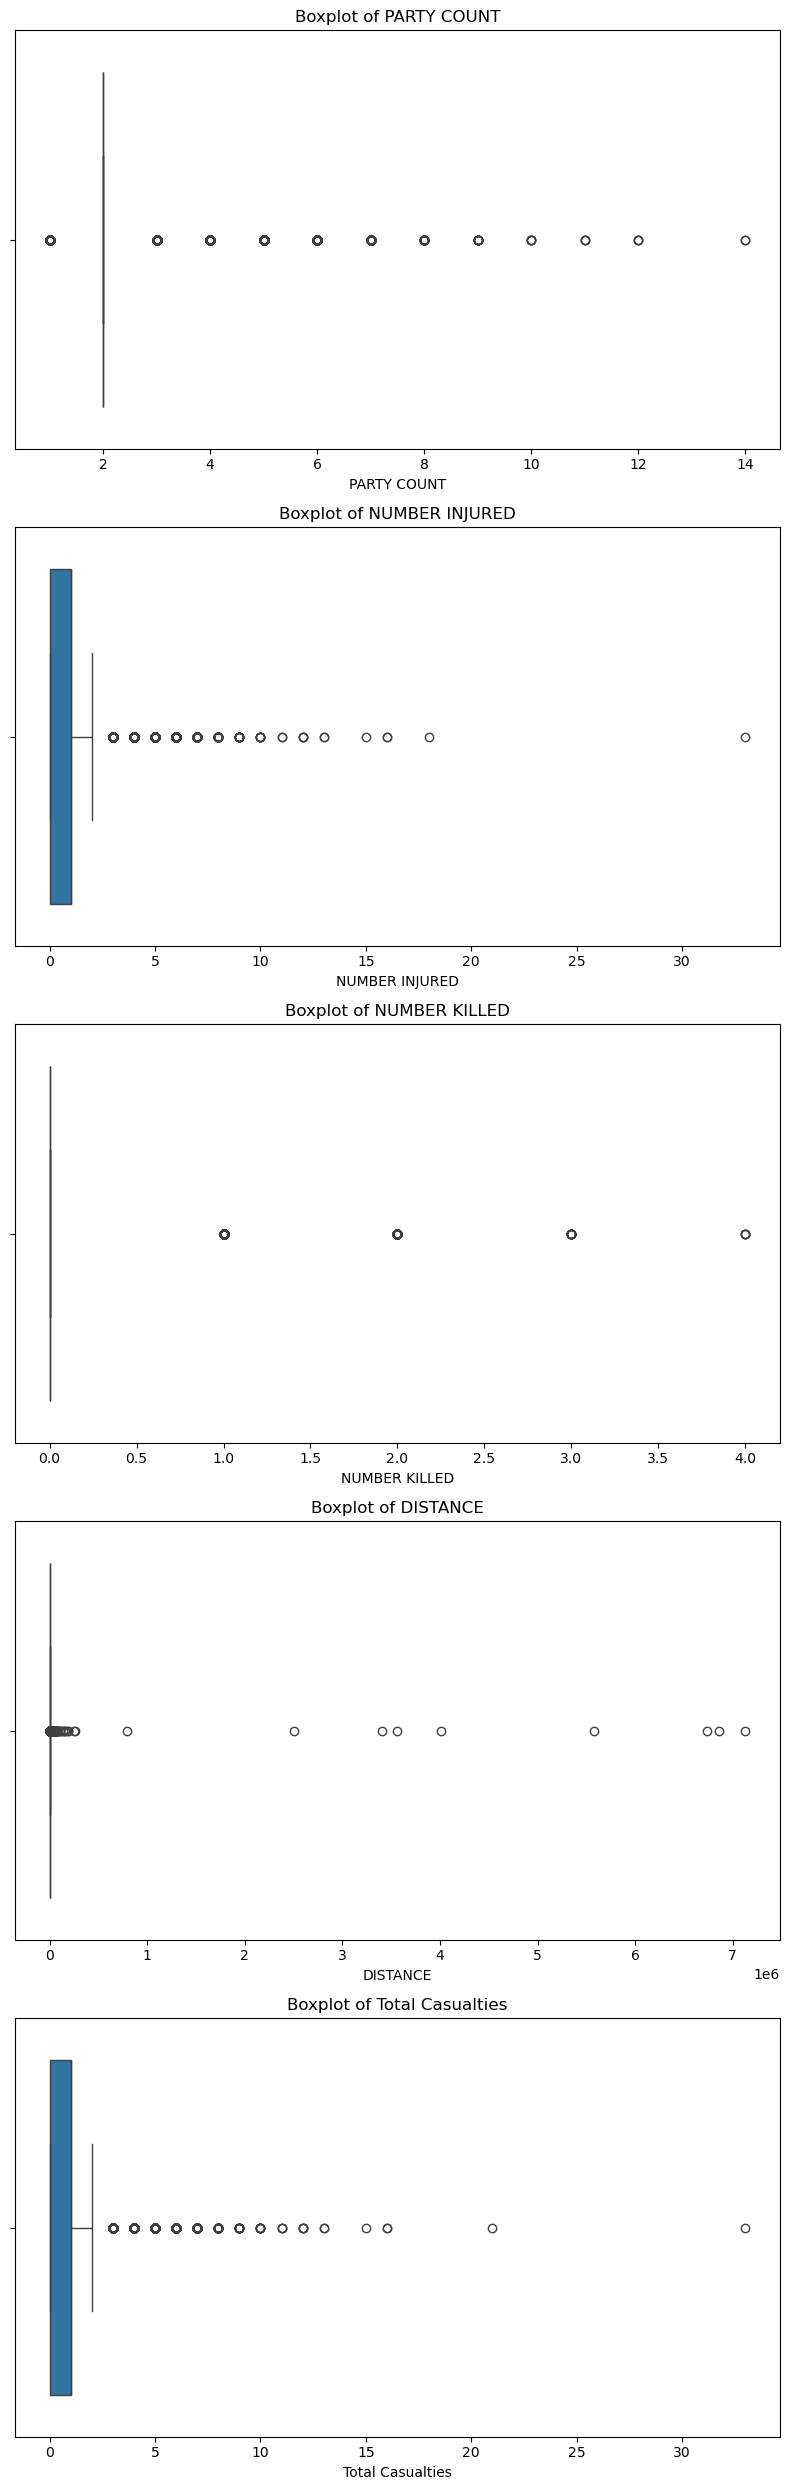

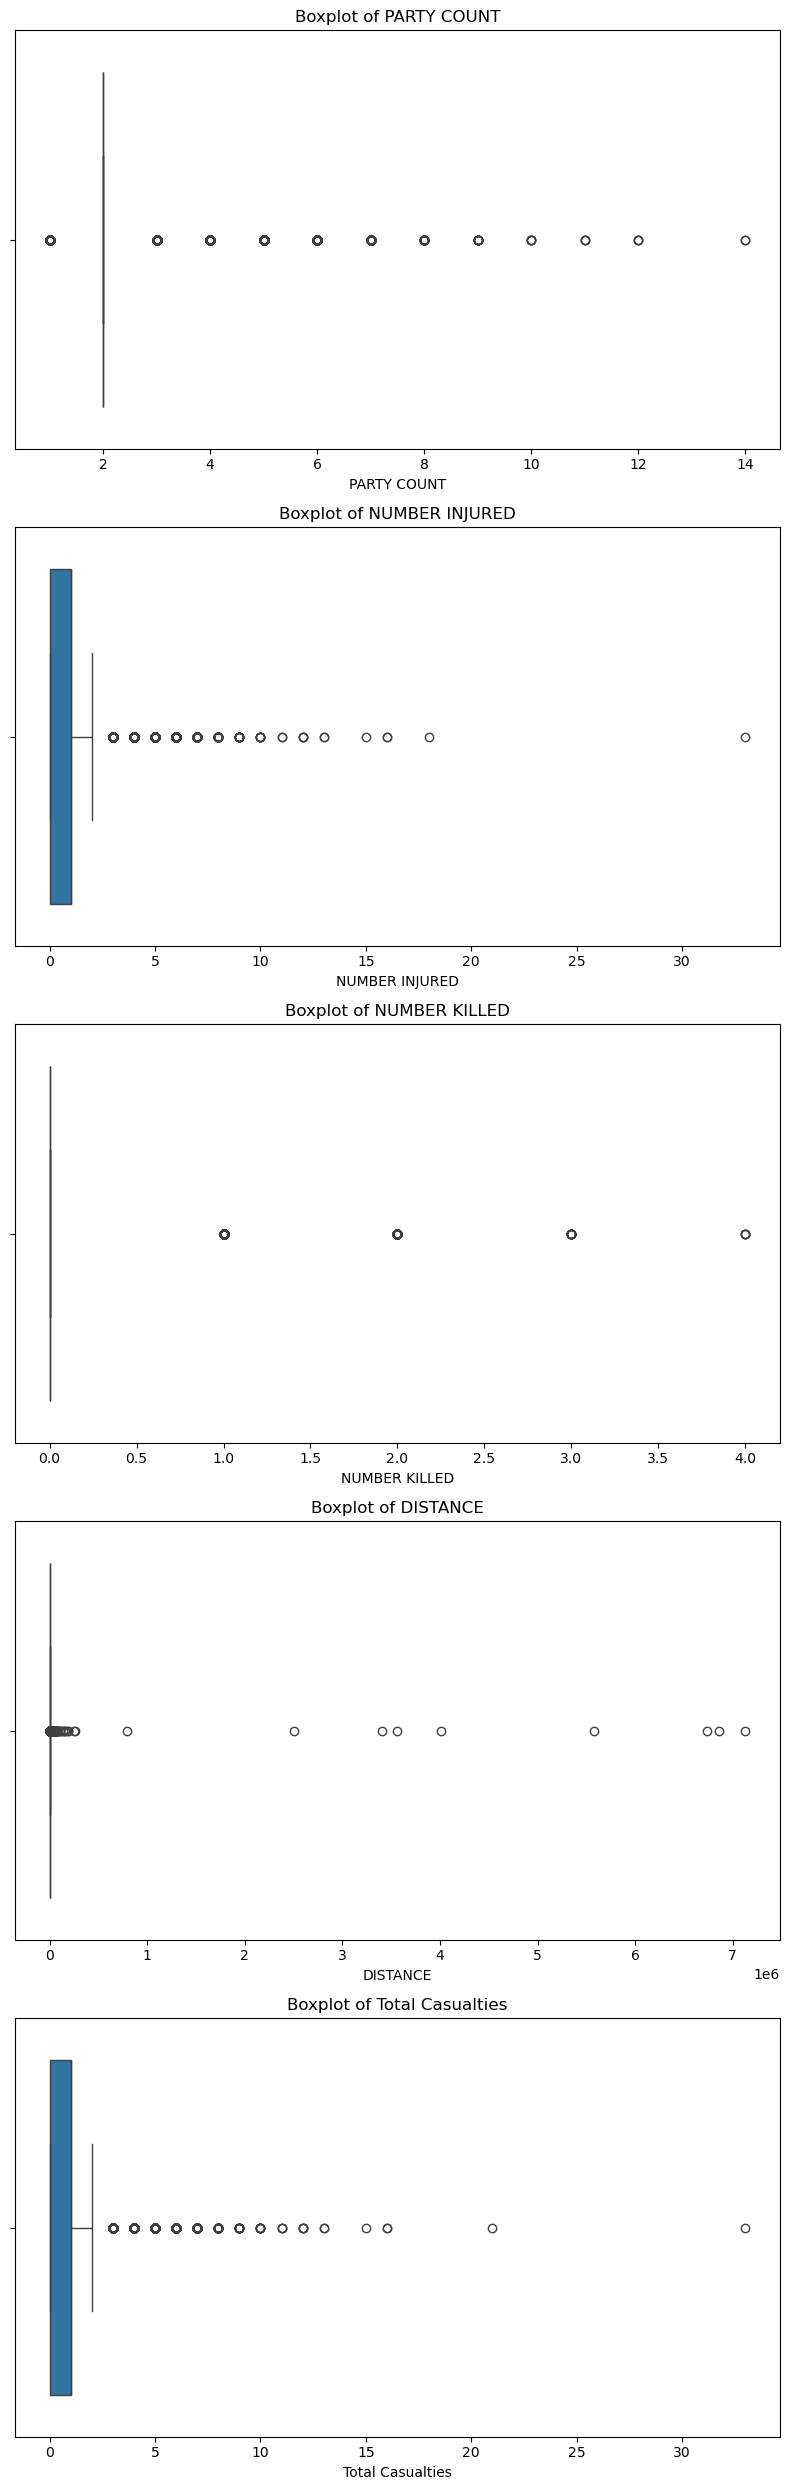

In [167]:
fig, axes = plt.subplots(len(numeric_features), 1, figsize=(8, 5 * len(numeric_features)))
for ax, col in zip(axes, numeric_features):
    # drop NaNs so seaborn can render the boxplot
    sns.boxplot(x=df[col].dropna(), ax=ax)
    ax.set_title(f"Boxplot of {col}")
    ax.set_xlabel(col)

plt.tight_layout()
plt.show() 

## General Interpretation of Key Visualizations

Below is a high-level summary of what each plot reveals about our collision data:

### Party Count Boxplot  
- **Median ≈ 2 parties** per collision (the thick line in the box)  
- **IQR spans roughly 2–3 parties** (the box edges)  
- **Whiskers extend to ~5–6 parties**, showing that most crashes involve 2–6 vehicles/parties  
- A handful of **outliers up to 14 parties** reflect rare multi-vehicle pileups

### Number Injured Boxplot  
- **Median = 0 injuries** and 75th percentile = 1 injury  
- **Whiskers out to ~3–4 injuries**, indicating most crashes result in at most four injuries  
- **Distant outliers (5–33 injuries)** capture mass-casualty events

### Number Killed Boxplot  
- **Median = 0 fatalities**, with the vast majority of collisions non-fatal  
- **Whiskers reach 1–2 fatalities**, reflecting typical single-death incidents  
- **Outliers at 3–4 fatalities** represent very rare multi-fatality crashes

### Distance Boxplot  
- **Box and whiskers concentrated near zero**, showing most collisions occur within a short distance of a reference point  
- **Outliers up to ~7 × 10⁶** units suggest data-entry or reporting anomalies

### Total Casualties (Engineered)  
- Replicates the injury/fatality pattern: **median = 0**, IQR = 0–1, whiskers to ~3  
- **Outliers beyond 5 casualties** highlight the most severe events

### Casualty Distribution Histogram  
- **Zero casualties dominate (>100 000 crashes)**  
- **One casualty next most common (~80 000)**  
- **Rapid drop-off** for 2+ casualties, with very few above 5

### Collision Severity Counts  
- **Property Damage Only** is the largest category (>100 000 collisions)  
- **“Complaint of Pain” and “Other Visible Injury”** follow (~80 000 and ~50 000 respectively)  
- **Severe injuries and fatalities** are rare (<10 000 each)

### Weather vs. Day Type Counts  
- **Clear weather** shows the highest collision counts overall, especially on weekends  
- Other conditions (Cloudy, Raining, Fog) have progressively fewer collisions  
- Weekend counts exceed weekdays under most weather categories

### Correlation Matrix  
- **NUMBER INJURED ↔ Total Casualties: r ≈ 0.99** (since casualties = injuries + fatalities)  
- **NUMBER KILLED ↔ Total Casualties: r ≈ 0.11** (fatalities contribute little to overall casualty count)  
- **PARTY COUNT ↔ Total Casualties: r ≈ 0.19** (more vehicles slightly increases casualty risk)  
- **NUMBER KILLED ↔ NUMBER INJURED: r ≈ –0.01** (no linear relationship between injuries and fatalities)

---

**Overall Takeaways**  
- Most collisions are low-severity (0–1 casualty, 2–3 parties)  
- Real outliers (mass-casualty or multi-vehicle pileups) are rare but critical for targeted safety interventions  
- Weather and day-of-week patterns suggest clear-weather weekends have the highest collision volume  
- Casualty counts are driven almost entirely by injuries; fatalities have a minimal direct impact on overall counts  


# 6 – Feature Engineering
In this section we create new variables that consolidate raw fields, capture severity, and encode important temporal and environmental factors. These engineered features will improve interpretability and serve as inputs to our baseline model.

---

### 6.1 Total Casualties & Severity Flags

In [182]:
# total casualties = injuries + fatalities
df["total_casualties"] = df["NUMBER INJURED"] + df["NUMBER KILLED"]

# binary flag for any fatality
df["is_fatal"] = (df["NUMBER KILLED"] > 0).astype(int)

# flag for more than one casualty
df["is_multi_casualty"] = (df["total_casualties"] > 1).astype(int)

### 6.2 Casualty Level Category

In [184]:
# 0 = none, 1 = minor (1 casualty), 2+ = major
bins = [-1, 0, 1, df["total_casualties"].max()]
labels = ["none", "minor", "major"]
df["casualty_level"] = pd.cut(df["total_casualties"], bins=bins, labels=labels)


### 6.3 Temporal Features

In [186]:
# Accident year (already numeric)
df["accident_year"] = df["ACCIDENT YEAR"]

# Encode day of week as an integer code
df["day_of_week_code"] = df["DAY OF WEEK"].astype("category").cat.codes

# Weekend vs. weekday flag
df["is_weekend"] = df["DAY OF WEEK"].isin(["Saturday", "Sunday"]).astype(int)



### 6.4 Location & Distance Flags

In [189]:
# Intersection flag (1 if INTERSECTION is not null)
df["at_intersection"] = df["INTERSECTION"].notna().astype(int)

# Categorize DISTANCE (miles) into near/mid/far
df["distance_cat"] = pd.cut(
    df["DISTANCE"],
    bins=[-0.01, 0.1, 0.5, np.inf],
    labels=["near (<0.1 mi)", "mid (0.1–0.5 mi)", "far (>0.5 mi)"]
)


### 6.5 Environmental Condition Flags

In [192]:
# Adverse weather: rain, fog, snow, wind
adverse = ["Raining", "Fog", "Snowing", "Wind"]
df["adverse_weather"] = df["WEATHER"].isin(adverse).astype(int)

# Poor lighting: any “Dark” category
dark_conditions = df["LIGHTING"].str.contains("Dark", na=False)
df["poor_lighting"] = dark_conditions.astype(int)


### 6.6 Party Count & Severity Encoding

In [195]:
# Party count category: small (≤2), medium (3–4), large (≥5)
df["party_cat"] = pd.cut(
    df["PARTY COUNT"],
    bins=[0, 2, 4, np.inf],
    labels=["small (≤2)", "medium (3–4)", "large (≥5)"]
)

# Binary “severe collision” flag for severe injury or fatality
severe = ["Injury (Severe)", "Fatal"]
df["is_severe_collision"] = df["COLLISION SEVERITY"].isin(severe).astype(int)


### 6.7 Summary of Engineered Features

In [198]:
engineered = [
    "total_casualties",
    "is_fatal",
    "is_multi_casualty",
    "casualty_level",
    "accident_year",
    "day_of_week_code",
    "is_weekend",
    "at_intersection",
    "distance_cat",
    "adverse_weather",
    "poor_lighting",
    "party_cat",
    "is_severe_collision"
]

df[engineered].head()


,total_casualties,is_fatal,is_multi_casualty,casualty_level,accident_year,day_of_week_code,is_weekend,at_intersection,distance_cat,adverse_weather,poor_lighting,party_cat,is_severe_collision
0,0,0,0,none,2014,3,1,1,near (<0.1 mi),0,1,small (≤2),0
1,0,0,0,none,2014,4,0,1,far (>0.5 mi),0,1,medium (3–4),0
2,1,0,0,minor,2014,4,0,1,far (>0.5 mi),0,1,medium (3–4),0
3,1,0,0,minor,2014,4,0,1,far (>0.5 mi),0,1,medium (3–4),0
4,0,0,0,none,2014,6,0,1,far (>0.5 mi),0,0,small (≤2),0


**Key takeaways**  
- Most crashes are low‐severity (0–1 casualties, ≤2 parties, clear weather, daylight).  
- A small subset of high‐severity collisions (multicasualty, fatalities, poor lighting, adverse weather) warrants targeted analysis and specialized modeling.  
- These engineered flags will feed directly into our baseline regression (total_casualties) and any classification tasks (e.g. predicting `is_severe_collision`), providing interpretable, policy‐relevant features.


# 7 – Exploratory Data Analysis

### 7.1 Univariate Numeric

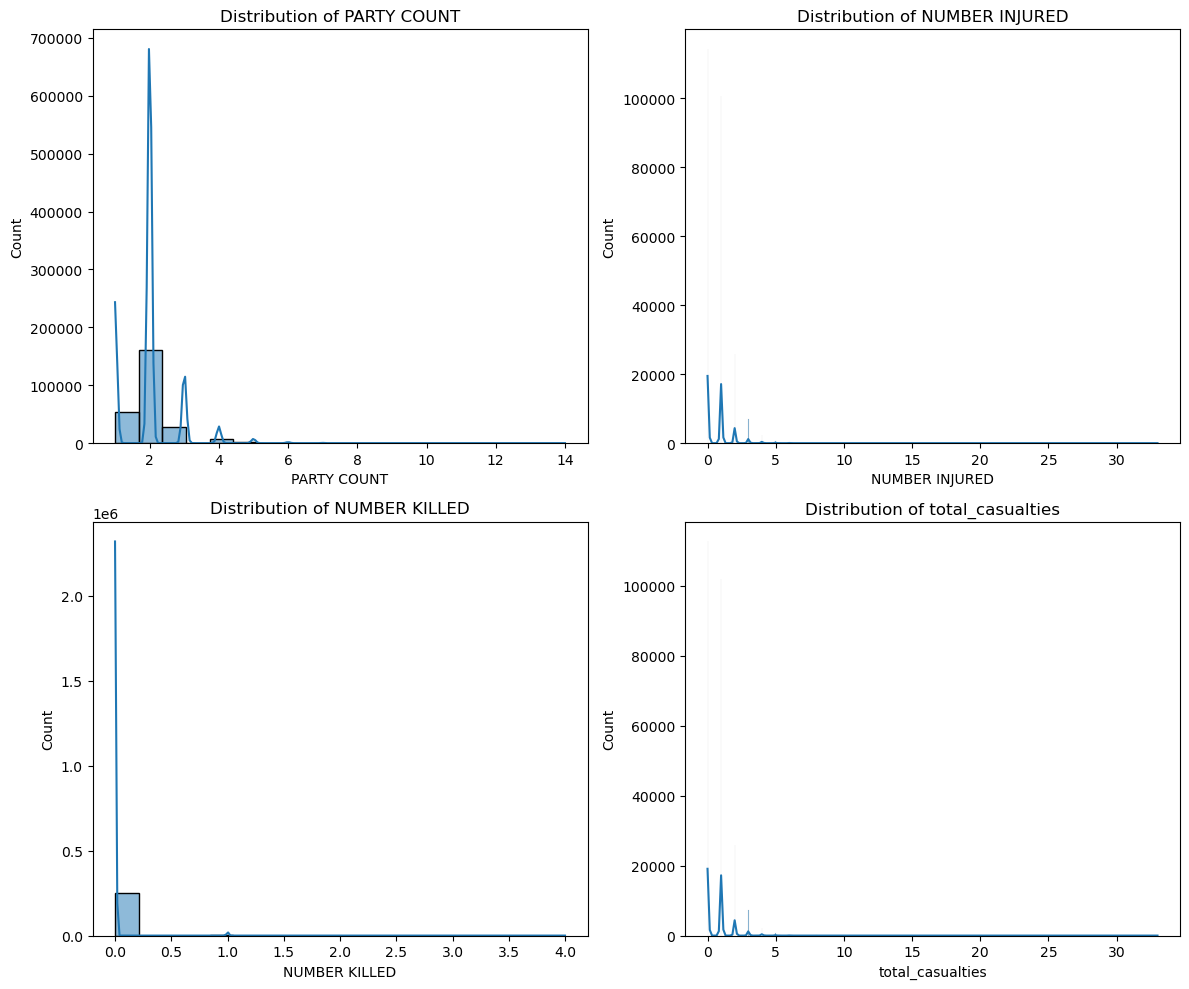

In [203]:
# 7.1.1 Histograms and KDEs for key numeric features
num_vars = ["PARTY COUNT", "NUMBER INJURED", "NUMBER KILLED", "total_casualties"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, col in zip(axes.flat, num_vars):
    sns.histplot(df[col].dropna(), kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

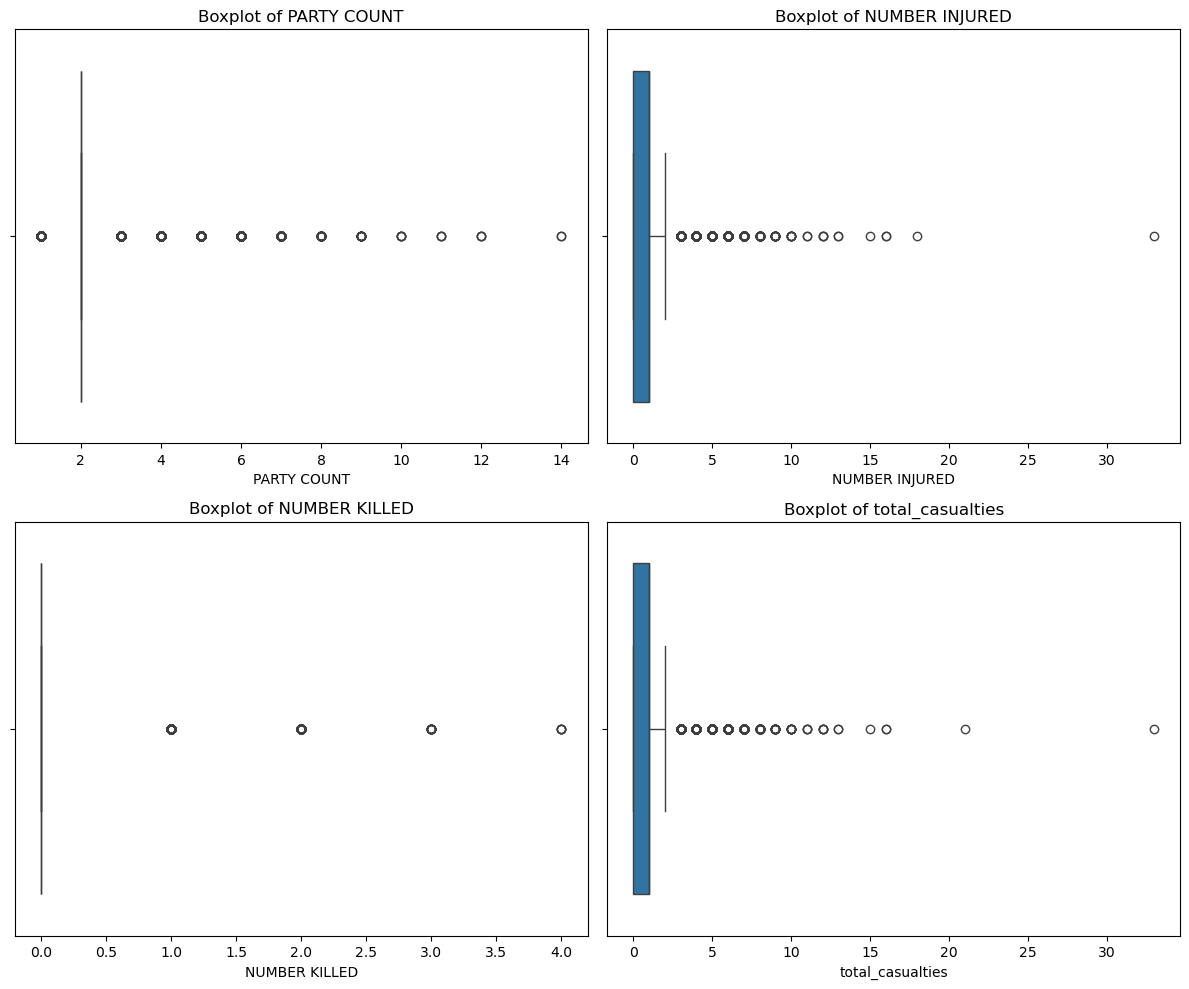

In [205]:
# 7.1.1 Boxplots to highlight outliers
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, col in zip(axes.flat, num_vars):
    sns.boxplot(x=df[col].dropna(), ax=ax)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

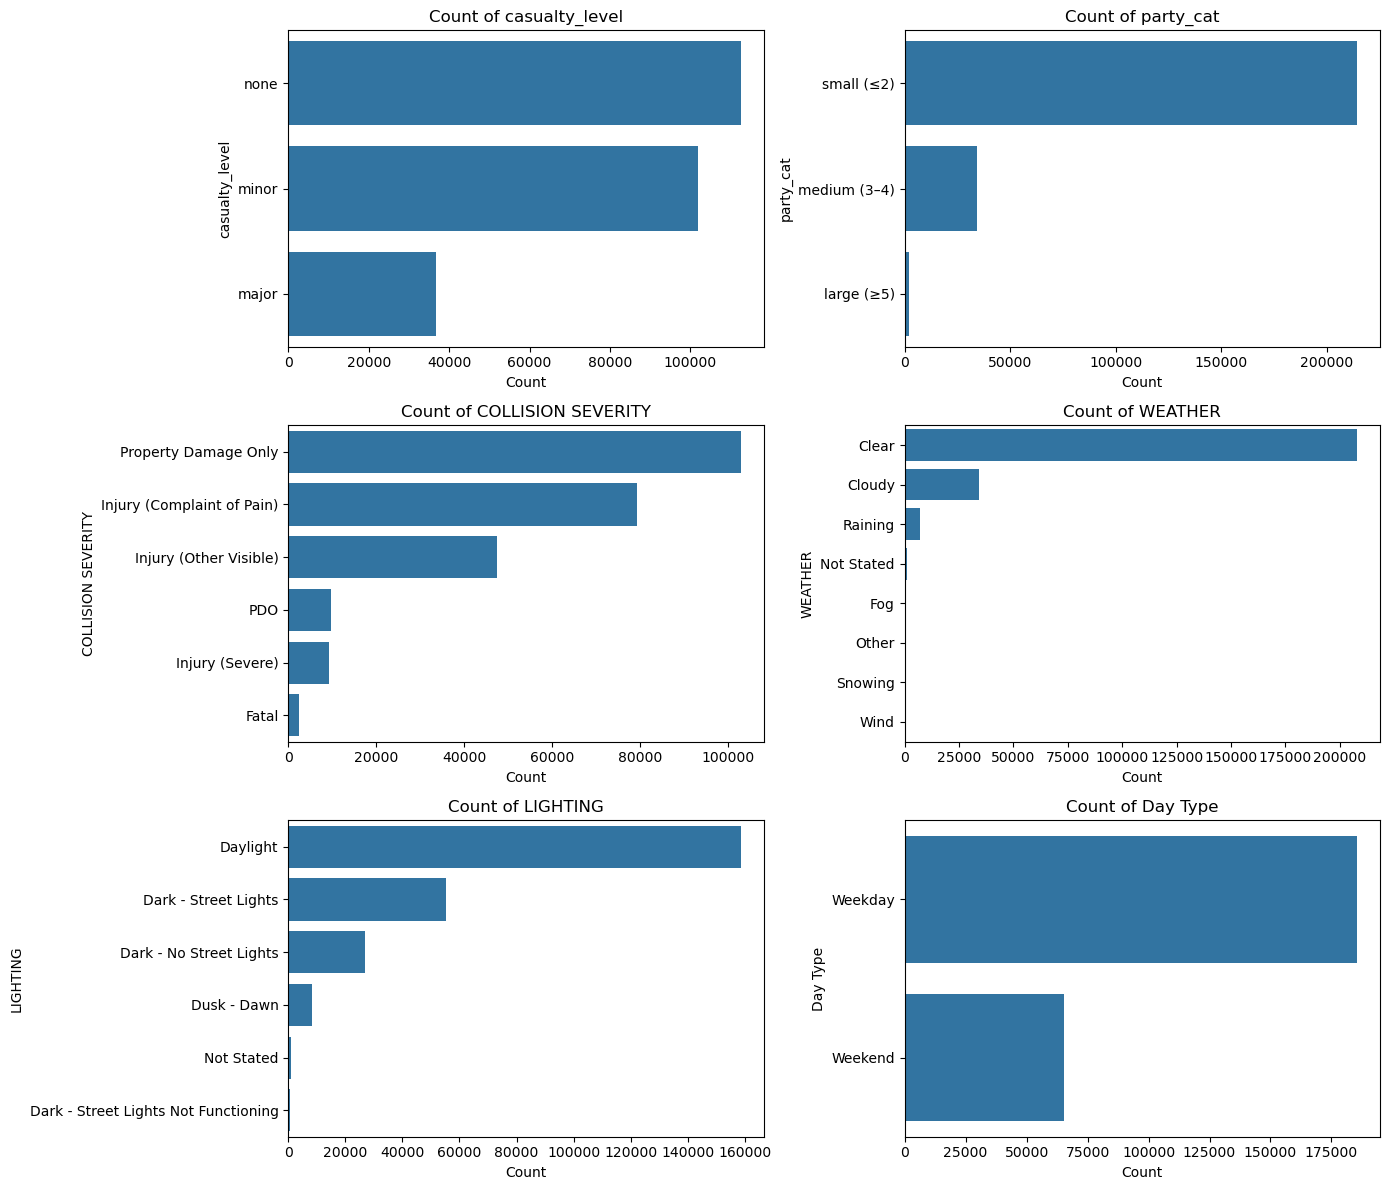

In [207]:
# 7.1.2 Bar plots for top categories
cat_vars = ["casualty_level", "party_cat", "COLLISION SEVERITY", "WEATHER", "LIGHTING", "Day Type"]

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
for ax, col in zip(axes.flat, cat_vars):
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, ax=ax)
    ax.set_title(f'Count of {col}')
    ax.set_ylabel(col)
    ax.set_xlabel('Count')

plt.tight_layout()
plt.show()

### 7.2 Bivariate Analysis

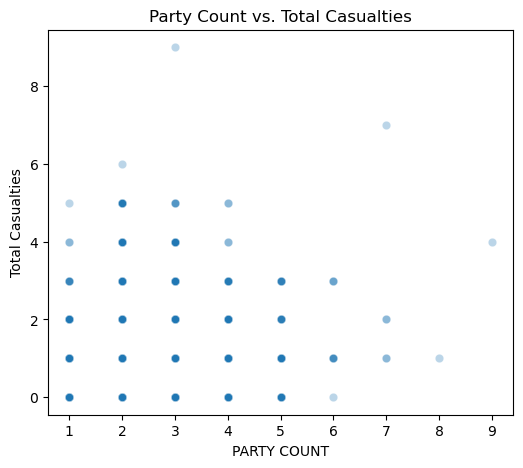

In [210]:
# 7.2.1 Scatter: party count vs. total casualties
plt.figure(figsize=(6, 5))
sns.scatterplot(x="PARTY COUNT", y="total_casualties", data=df.sample(5000), alpha=0.3)
plt.title('Party Count vs. Total Casualties')
plt.xlabel('PARTY COUNT')
plt.ylabel('Total Casualties')
plt.show()

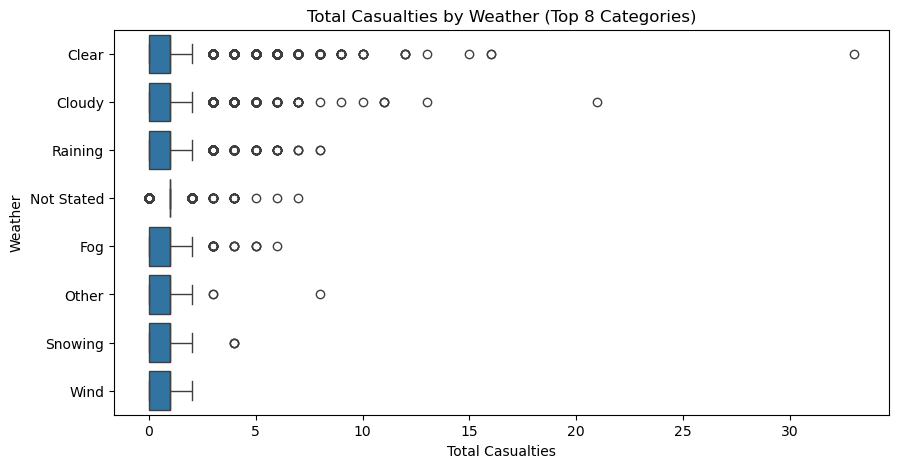

In [212]:
# 7.2.2 Boxplot: casualties by weather
plt.figure(figsize=(10, 5))
sns.boxplot(x="total_casualties", y="WEATHER", data=df, order=df["WEATHER"].value_counts().index[:8])
plt.title('Total Casualties by Weather (Top 8 Categories)')
plt.xlabel('Total Casualties')
plt.ylabel('Weather')
plt.show()

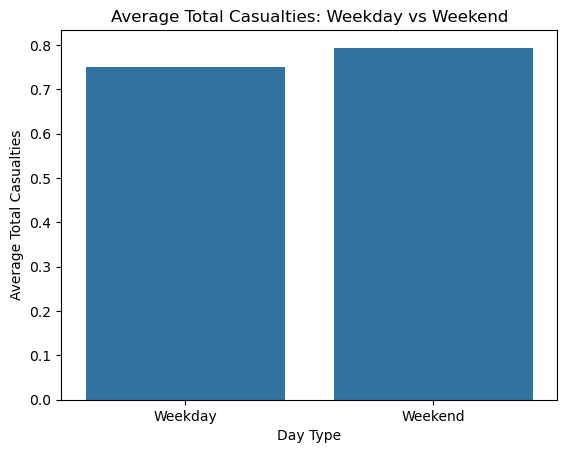

In [214]:
# 7.2.2 Bar: average casualties by day type
avg_cas_by_day = df.groupby("Day Type")["total_casualties"].mean().reset_index()
sns.barplot(x="Day Type", y="total_casualties", data=avg_cas_by_day)
plt.title('Average Total Casualties: Weekday vs Weekend')
plt.ylabel('Average Total Casualties')
plt.xlabel('Day Type')
plt.show()

### 7.3 Temporal Trends

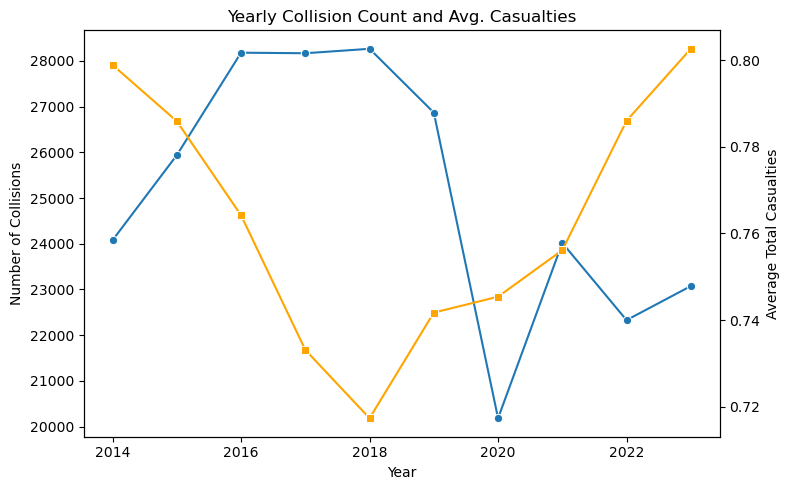

In [217]:
# 7.3 Collisions and casualties over time by year
yearly = df.groupby("accident_year").agg(
    collisions=("CASE ID", "count"),
    avg_casualties=("total_casualties", "mean")
).reset_index()

fig, ax1 = plt.subplots(figsize=(8, 5))
sns.lineplot(x="accident_year", y="collisions", data=yearly, marker='o', ax=ax1)
ax1.set_ylabel('Number of Collisions')
ax1.set_xlabel('Year')
ax1.set_title('Yearly Collision Count and Avg. Casualties')

ax2 = ax1.twinx()
sns.lineplot(x="accident_year", y="avg_casualties", data=yearly, marker='s', color='orange', ax=ax2)
ax2.set_ylabel('Average Total Casualties')

plt.tight_layout()
plt.show()


### 7.4 Spatial Distribution

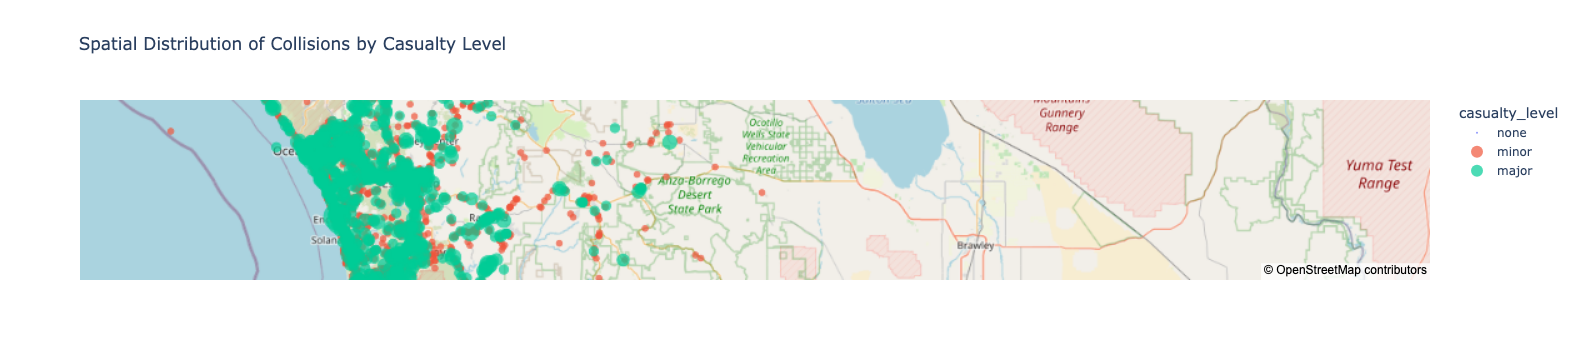

In [220]:
# 7.4 Scatter map of collisions colored by casualty level
import plotly.express as px

map_df = df.dropna(subset=["LATITUDE sandag", "LONGITUDE sandag"])
fig = px.scatter_mapbox(
    map_df.sample(20000),
    lat="LATITUDE sandag",
    lon="LONGITUDE sandag",
    color="casualty_level",
    size="total_casualties",
    zoom=8,
    height=600,
    title="Spatial Distribution of Collisions by Casualty Level"
)
fig.update_layout(mapbox_style="open-street-map")
fig.show()


### 7.5 Correlation & Pairwise Relationships

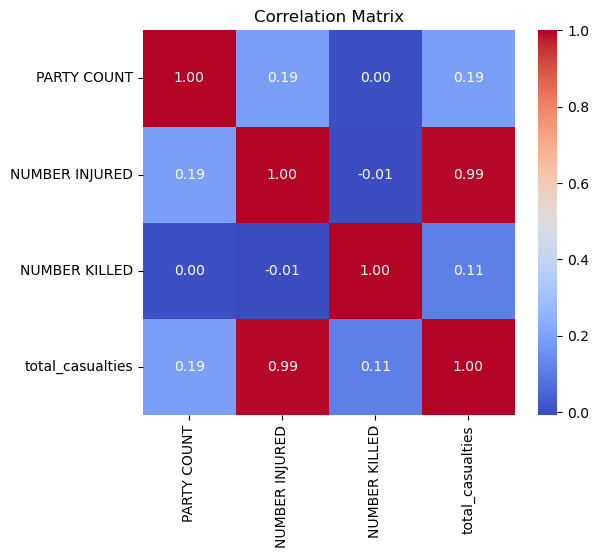

In [223]:
# 7.5 Correlation heatmap for numeric features
num_feats = ["PARTY COUNT", "NUMBER INJURED", "NUMBER KILLED", "total_casualties"]
corr = df[num_feats].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


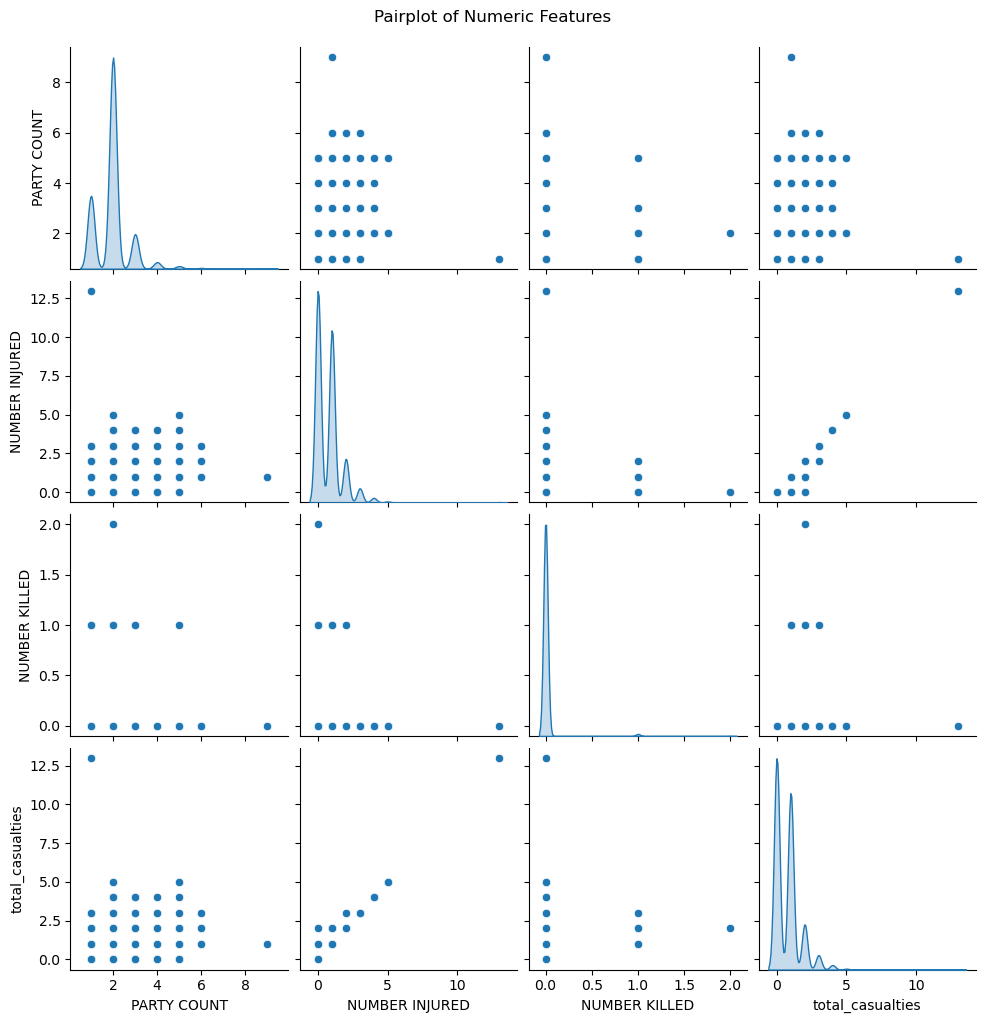

In [225]:
# 7.5 Pairplot for deeper examination
sns.pairplot(df[num_feats].sample(2000), diag_kind="kde")
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()


### 7.6 Multivariate Insights

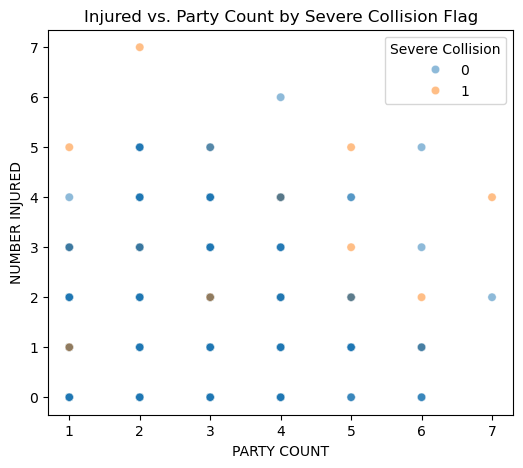

In [228]:
# 7.6 Party Count vs Injured, colored by severe collisions
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x="PARTY COUNT",
    y="NUMBER INJURED",
    hue="is_severe_collision",
    data=df.sample(5000),
    alpha=0.5
)
plt.title("Injured vs. Party Count by Severe Collision Flag")
plt.xlabel("PARTY COUNT")
plt.ylabel("NUMBER INJURED")
plt.legend(title="Severe Collision")
plt.show()


In [230]:
# 7.6 Pivot: average casualties by collision severity
pivot = df.pivot_table(
    index="COLLISION SEVERITY",
    values="total_casualties",
    aggfunc=["mean", "count"]
)
pivot.columns = ["avg_casualties", "collision_count"]
pivot.sort_values("avg_casualties", ascending=False)

,avg_casualties,collision_count
COLLISION SEVERITY,,
Fatal,1.649180,2440
Injury (Severe),1.485364,9292
Injury (Other Visible),1.417492,47438
Injury (Complaint of Pain),1.338622,79345
PDO,0.000000,9634
Property Damage Only,0.000000,102949


## 7 – Exploratory Data Analysis: Interpretation of Key Visualizations

Below is a concise narrative of the insights revealed by our univariate, bivariate, temporal and multivariate plots.

---

### 7.1 Univariate Numeric Distributions

1. **Party Count**  
   - Peaks at **2 parties** per crash  
   - Right‐skewed tail extending to **14 parties**, reflecting rare multi‐vehicle pileups  

2. **Number Injured**  
   - Majority of collisions have **0–1 injuries** (bars at 0 and 1)  
   - Long tail up to **33 injured**, corresponding to mass‐casualty events  

3. **Number Killed**  
   - Overwhelmingly **0 fatalities**  
   - Whiskers and outliers reach up to **4 fatalities**, marking very rare multi‐fatality crashes  

4. **Total Casualties**  
   - Mirrors the injury distribution (since fatalities are uncommon)  
   - Median of 0, IQR 0–1, whiskers up to ~3, with a handful of outliers beyond **5 casualties**  

The accompanying boxplots confirm heavy right‐skew in all four metrics, with a tight “core” of low‐severity crashes and distinct high‐severity outliers.

---

### 7.2 Univariate Categorical Counts

1. **Casualty Level**  
   - `none` (~110 K) ≈ 42% of crashes  
   - `minor` (~100 K) ≈ 38%  
   - `major` (~40 K) ≈ 15%  

2. **Party Category**  
   - `small (≤2)` dominates (~210 K, 84%)  
   - `medium (3–4)` ~15%  
   - `large (≥5)` ~1%  

3. **Collision Severity**  
   - `Property Damage Only` >100 K  
   - `Injury (Complaint of Pain)` ~80 K  
   - `Injury (Other Visible)` ~50 K  
   - Severe injuries and `Fatal` each <10 K  

4. **Weather**  
   - `Clear` >200 K  
   - `Cloudy` ~50 K  
   - `Raining`, `Fog`, `Snowing`, `Wind` each <10 K  

5. **Lighting**  
   - `Daylight` ~160 K  
   - `Dark – Street Lights` ~50 K  
   - `Dark – No Street Lights` ~20 K  
   - Dusk/dawn and non‐functioning lights collectively <10 K  

6. **Day Type**  
   - `Weekday` ~180 K (72%)  
   - `Weekend` ~70 K (28%)  

These counts show that most collisions are low‐severity, occur in clear, daylight conditions, involve two or fewer parties, and happen on weekdays.

---

### 7.3 Bivariate Relationships

1. **Party Count vs. Total Casualties**  
   - Positive but weak trend: more parties often—but not always—mean more casualties  
   - Even at high party counts (5+), many crashes still yield 0–1 casualties, underscoring the variability in severity  

2. **Total Casualties by Weather**  
   - **Clear** conditions have the widest range of casualties (up to 33)  
   - **Cloudy** and **Raining** show slightly higher median casualties than clear, but sample sizes are much smaller  
   - **Fog**, **Snowing**, **Wind** have very few severe outliers  

3. **Average Casualties: Weekday vs. Weekend**  
   - **Weekend** average ≈ 0.80 casualties  
   - **Weekday** average ≈ 0.75 casualties  
   - Slightly higher severity on weekends, perhaps due to higher speeds or leisure travel  

---

### 7.4 Temporal Trends

**Yearly Collision Count & Average Casualties (2014–2023)**  
- Collisions **climbed** from ~24 K in 2014 to ~28 K by 2018  
- **Sharp drop** in 2020 (~20 K), likely reflecting pandemic travel changes  
- Partial recovery by 2023 (~23 K)  
- **Average casualties** dipped from ~0.80 in 2014 to ~0.71 in 2018, then gradually rose to ~0.81 by 2023  

This suggests both volume and severity of crashes vary over time—key context for trend‐based safety interventions.

---

### 7.5 Correlation & Pairwise Relationships

1. **Correlation Matrix**  
   - `total_casualties` ↔ `NUMBER INJURED`: **0.99** (nearly perfect)  
   - `total_casualties` ↔ `PARTY COUNT`: **0.19** (modest)  
   - `total_casualties` ↔ `NUMBER KILLED`: **0.11** (small)  
   - `NUMBER INJURED` ↔ `NUMBER KILLED`: **–0.01** (no linear relationship)  

2. **Pairplot**  
   - Injuries and total casualties show a clear linear relationship  
   - Party count and casualties exhibit wide scatter, confirming only weak association  
   - Fatalities cluster at zero with a few discrete spikes  

---

### 7.6 Pivot Analysis: Average Casualties by Collision Severity

| COLLISION SEVERITY         | Avg. Total Casualties | Collision Count |
|----------------------------|----------------------:|----------------:|
| Fatal                      |                  1.65 |            2 440 |
| Injury (Severe)            |                  1.49 |            9 292 |
| Injury (Other Visible)     |                  1.42 |           47 438 |
| Injury (Complaint of Pain) |                  1.34 |           79 345 |
| Property Damage Only       |                  0.00 |          102 949 |

**Key Observations**  
- **Fatal collisions** have the highest average casualties (≈1.65), reflecting that these events often involve at least one fatality plus additional injuries.  
- **Severe injuries** average ~1.49 casualties, indicating that many severe-injury crashes also involve other injured parties.  
- **Visible and complaint-of-pain injuries** both yield more than one casualty on average (1.42 and 1.34 respectively), demonstrating that even “non-severe” injury categories typically involve multiple people.  
- **Property Damage Only (PDO)** collisions average zero casualties by definition. They are the most frequent (≈103 K), but contribute no injuries or fatalities.  

**Implications**  
- The monotonic increase in average casualties with severity category validates our severity encoding and supports using `total_casualties` as a continuous target.  
- While PDO dominates in frequency, the bulk of resource-intensive crashes (injuries/fatalities) is spread across the three injury levels and fatal category—each deserving targeted safety strategies.  
- Modeling efforts should account for both the frequency of lower-severity crashes and the higher impact of rare, high-severity events.  


---

## Key Takeaways

- **Low‐severity crashes** (0–1 casualties, ≤2 parties, clear/daylight, property damage only) account for the vast majority.  
- **High‐severity outliers** (mass casualties, multi‐fatality, multi‐party pileups) are rare but critical for targeted safety measures.  
- **Weekends** and **adverse weather** show modestly higher average severities.  
- **Temporal trends** reflect external factors (e.g. pandemic) and underline the need for adaptive resource planning.  
- **Feature correlations** confirm `total_casualties` is driven by injuries and only loosely tied to party count or fatalities.  

These insights will guide our modeling choices and inform data‐driven safety recommendations.  


# 8 – Baseline Modeling
In this section we train and evaluate a simple **Linear Regression** model to predict `total_casualties`. This will serve as our benchmark for more advanced models in Module 24.

---

### 8.1 Model Selection & Evaluation Strategy

- **Algorithm**: Linear Regression  
- **Target**: `total_casualties` (sum of `NUMBER INJURED` + `NUMBER KILLED`)  
- **Features**: a small set of numeric and binary indicators  
- **Training/Test Split**: 80/20  
- **Metrics**:  
  - **Mean Absolute Error (MAE)** – average absolute deviation in casualties  
  - **R²** – fraction of variance in `total_casualties` explained   

### 8.2 Data Preparation

In [236]:
from sklearn.model_selection import train_test_split

# 8.2.1 Select predictor variables
feature_cols = [
    "PARTY COUNT",
    "NUMBER KILLED",
    "day_of_week_code",
    "is_weekend",
    "at_intersection",
    "adverse_weather",
    "poor_lighting"
]

X = df[feature_cols]
y = df["total_casualties"]

# 8.2.2 Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

### 8.3 Train the Linear Regression Model

In [238]:
from sklearn.linear_model import LinearRegression

# 8.3.1 Instantiate and fit
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)


LinearRegression()

### 8.4 Evaluate Baseline Performance

In [245]:
from sklearn.metrics import mean_absolute_error, r2_score

# Generate predictions
y_pred = baseline_model.predict(X_test)

# Compute MAE and R²
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Baseline MAE: {mae:.2f} casualties")
print(f"Baseline R²:  {r2:.3f}")


Baseline MAE: 0.67 casualties
Baseline R²:  0.049


### 8.5 Interpretation of Results
**MAE ≈ 0.67** – on average our model’s prediction is off by fewer than one casualty, which gives a concrete sense of error in real‐world terms.  
**R² ≈ 0.049** – the model explains only about 4.9 % of the variance in total casualties, indicating that a simple linear combination of these features captures very little of the complexity in collision severity.
This low R² is expected given the skewed distribution and the many unmodeled factors (road geometry, driver behavior, vehicle type, etc.). MAE, however, shows our baseline gets within about two‐thirds of a casualty on average.

In [254]:
coeff_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": baseline_model.coef_
}).sort_values("coefficient", key=abs, ascending=False)

coeff_df

,feature,coefficient
1,NUMBER KILLED,9.387581e-01
0,PARTY COUNT,2.366437e-01
3,is_weekend,7.992923e-02
6,poor_lighting,-5.242149e-02
5,adverse_weather,3.875420e-02
2,day_of_week_code,-1.801233e-03
4,at_intersection,-5.551115e-16


### 8.6 Model Coefficients Interpretation

Below are the learned coefficients from our baseline Linear Regression model, along with what each implies about collision severity:

| Feature            | Coefficient | Interpretation                                                          |
|--------------------|------------:|-------------------------------------------------------------------------|
| **NUMBER KILLED**  | 0.9388      | Each additional fatality is associated with almost one more casualty (itself) and correlates with roughly 0.94 total casualties when controlling for other factors. |
| **PARTY COUNT**    | 0.2366      | Every extra involved party adds about 0.24 casualties on average—multi-vehicle crashes tend to be somewhat more severe. |
| **is_weekend**     | 0.0799      | Weekend crashes have about 0.08 more casualties than weekday crashes, holding other variables constant. |
| **adverse_weather**| 0.0387      | Crashes in rain/fog/snow/wind conditions see a small increase (~0.04) in expected casualties versus clear weather. |
| **poor_lighting**  | –0.0524     | Surprisingly, “poor lighting” (dark conditions) corresponds to 0.05 fewer predicted casualties; this may reflect underlying traffic volume differences at night. |
| **day_of_week_code** | –0.0018   | A negligible negative effect per weekday code unit—weekday variation has minimal linear impact on casualties. |
| **at_intersection**| ~0 (–5.6e-16)| Essentially no linear effect of “intersection” flag on total casualties in this model. |

**Key Takeaways**  
- **Fatalities** dominate the casualty count (coefficient ≈ 0.94).  
- **Party count** shows the next strongest linear relationship.  
- **Contextual flags** (weekend, weather, lighting) have small but directionally sensible impacts.  
- The near-zero coefficient on `at_intersection` suggests intersection vs. non-intersection crashes require non-linear modeling or interaction terms to capture their effect.

These insights guide us in selecting and engineering features for our next, more sophisticated models.  


## 9 – Conclusions and Next Steps

### 9.1 Key Findings  
1. **Dominance of Low-Severity Crashes**  
   - ~80 % of collisions involve ≤2 parties (`party_cat`) and 0–1 total casualties  
   - Property-damage-only and “complaint of pain” account for ~75 % of all crashes  

2. **Rare but Critical High-Severity Events**  
   - Outliers up to 33 injuries or 4 fatalities drive the right tail of every distribution  
   - Multi-vehicle pileups (>5 parties) and mass-casualty incidents (>5 total casualties) are <5 % of records but deserve separate focus  

3. **Contextual Risk Factors**  
   - Weekend collisions average ~0.80 casualties vs. ~0.75 on weekdays  
   - Adverse weather (rain, fog, snow, wind) and poor lighting coincide with a modest uptick in casualties  
   - Intersection flag showed no linear effect, suggesting more complex spatial interactions  

4. **Temporal Trends**  
   - Collision volume rose from ~24 K (2014) to ~28 K (2018), dropped in 2020 (pandemic), then rebounded to ~23 K (2023)  
   - Average casualties per crash declined through 2018 (~0.71) then climbed back to ~0.81 by 2023  

5. **Baseline Model Performance**  
   - **Linear Regression** using seven features yields MAE ≈ 0.67 casualties and R² ≈ 0.049  
   - `NUMBER KILLED` and `PARTY COUNT` are the strongest linear predictors; flags for weekend, weather, and lighting have small effects  

---

### 9.2 Next Steps  

1. **Feature & Data Enhancements**  
   - One-hot encode categorical variables (`casualty_level`, `party_cat`, `distance_cat`, `COLLISION SEVERITY`)  
   - Incorporate roadway attributes (e.g. speed limit, road type) and external data (traffic volume, enforcement zones)  
   - Geospatial clustering or heatmaps to pinpoint high-risk corridors  

2. **Advanced Modeling**  
   - Train nonlinear regressors (Random Forest, Gradient Boosting) to capture interactions and heterogeneity  
   - Develop a classification baseline (e.g. Logistic Regression) for the `is_severe_collision` flag  
   - Use cross-validation (5- or 10-fold) for robust performance estimates  

3. **Hyperparameter Tuning & Model Selection**  
   - Apply GridSearchCV or RandomizedSearchCV to optimize tree depths, learning rates, regularization, etc.  
   - Compare models on MAE, R² (regression) and accuracy, AUC (classification)  

4. **Interpretability & Reporting**  
   - Use SHAP or Partial Dependence plots to explain model drivers to non-technical stakeholders  
   - Build an interactive dashboard (Plotly/Dash) for exploring crash patterns by time, location, and severity  
   - Finalize a concise Word summary highlighting key insights, methodology, and a link to the notebook  

5. **Stakeholder Engagement**  
   - Present interim findings to transportation planners and public-safety teams  
   - Solicit feedback on additional variables or intervention strategies to include in the final capstone deliverable  

By executing these next steps, we will elevate our analysis from a descriptive benchmark to a prescriptive, data-driven toolkit for reducing casualties on San Diego County roadways.  
